# Pipeline & Transformer

這篇內容是來自於[這裡](https://github.com/jem1031/pandas-pipelines-custom-transformers)詳細介紹`pipeline`&`Transformer`用法。非常推薦能看一下原文，按著例子做一次。

在整理資料的時候，其實都喜歡所見即所得(what you type is what you see)。但是這種資料整理的方式在日後比較難管理，比如說，下圖是喵喵在整理資料特徵的一小段`code`

![code](./img/feature_eng_messy.png)

不用說別人看不懂，喵喵自己事後在看的時候也是，暈頭轉向/不知所云/亂七八糟...雖然一時的邏輯都說得通，但是這種用後即丟的程式碼。似乎很難維護。
> “Any fool can write code that a computer can understand. Good programmers write code that humans can understand.” — Martin Fowler

雖然說我的工作不是寫出優雅乾淨的程式碼(通常髒活~~dirty work~~成分居多)，可是也應該期許自己不是個蠢蛋吧XD

_____
要能管理資料清理，就必須把一些方法盡可能的抽象化，易於重複使用。這篇的主旨是在說明這件事情，如何利用`scikit-learn`裡面的`pipeline`和`transformer`來**優雅地**完成(進入模型前)的資料清洗。

如果想把資料前處理，抽象成為人類能理解的方式，例如
1. 類別型資料
    -  取出欄位
    -  one hot encoding
    
2. 數值型資料
    - 取出欄位
    - 填補缺失值
    - 轉成log scale
3. 標準化資料(Standarize)

這樣每個小工作就變成清晰且易於除錯了。
____

# 範例

範例中我們要對欄位`permit_status`做分類的預測，由於我們只需要熟悉資料清理`pipeline`的使用，用最簡單的方式做模型建立(也不需要搞清楚這個資料集到底在幹嘛XXD)。

1. 只使用`attendance`作為變數(`x`)
2. 模型為LogisticRegression
3. 計算auc score

In [8]:
import pandas as pd 
import numpy as np 
%matplotlib inline

In [3]:
df = pd.read_csv('./Special_Events_Permits_2016.csv')
df.head().T

,0,1,2,3,4
application_date,12/09/2015 12:00:00 AM,01/07/2016 12:00:00 AM,01/21/2016 12:00:00 AM,01/21/2016 12:00:00 AM,01/21/2016 12:00:00 AM
permit_status,Complete,Complete,Complete,Complete,Complete
permit_type,Special Event,Special Event,Special Event,Special Event,Special Event
event_category,Athletic,Commercial,Community,Community,Community
event_sub_category,Run/Walk,NaN,NaN,NaN,NaN
name_of_event,See Jane Run Women's Half Marathon and 5K,Capitol Hill Block Party,Sounders FC March to the Match (7.09),Sounders FC March to the Match (7.13),Sounders FC March to the Match (7.31)
year_month_app,S16JY044,S16JY046,S16JY074,S16JY075,S16JY076
event_start_date,07/10/2016 12:00:00 AM,07/22/2016 12:00:00 AM,07/09/2016 12:00:00 AM,07/13/2016 12:00:00 AM,07/31/2016 12:00:00 AM
event_end_date,07/10/2016 12:00:00 AM,07/24/2016 12:00:00 AM,07/09/2016 12:00:00 AM,07/13/2016 12:00:00 AM,07/31/2016 12:00:00 AM
event_location_park,Gas Works Park,NaN,NaN,NaN,NaN


In [3]:
# outcome : permit_status
df.permit_status.unique()

array(['Complete', 'Cancelled', 'In Process'], dtype=object)

切切測試/訓練集

In [4]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,random_state= 4321)

In [5]:
df_train.shape

(396, 15)

In [6]:
df_test.shape

(133, 15)

數值化`y_train` & `y_test`

In [10]:
import numpy as np 
y_train = np.where(df_train.permit_status == 'Complete',1,0)
X_train = df_train[['attendance']].fillna(0)

y_test = np.where(df_test.permit_status == 'Complete',1,0)
X_test = df_test[['attendance']].fillna(0)

模型亂入

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=5678)

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
p_pred_train = model.predict_proba(X_train)[:,1]

測試集AUC score 
- model預測與baseline比較

In [18]:
from sklearn.metrics import roc_auc_score

p_baseline = [y_train.mean()]*len(y_test)
p_pred_test = model.predict_proba(X_test)[:,1]

auc_base = roc_auc_score(y_test, p_baseline) 
auc_test = roc_auc_score(y_test, p_pred_test)

print('baseline auc:{}'.format(auc_base))
print('test auc:{:.2f}'.format(auc_test))

baseline auc:0.5
test auc:0.58


# Transformers

比較一下兩種在sklearn裡面很好用的基礎類別

Transformer|Estimator|
:--|--|
資料清理/轉換|建模(modeling)|
`fit`:對訓練資料尋找適當參數| `fit`: 對訓練資料擬合尋找適當參數|
`transform`:作用在測試或訓練資料|`predict`:作用在測試或訓練資料|

Transformer|Estimator|
:---:|:---:|
`StandardScalar`|`LogisticRegression`|
`fit`對每個欄位(特徵)找到平均值,標準差|`fit`在羅吉斯回歸中找到符合公式的參數|
`transform`減去平均除以標準差(正規化)|`predict`塞入公式預測新資料|

In [25]:
## multiple transformer 
from sklearn.preprocessing import (Imputer, PolynomialFeatures, StandardScaler)

沒人想要者麼寫 ....醜到爆炸

In [26]:

imputer = Imputer()
quadratic = PolynomialFeatures()
standarizer = StandardScaler()

# 
X_train_imp = imputer.fit_transform(X_train)
X_train_quad = quadratic.fit_transform(X_train_imp)
X_train_final = standarizer.fit_transform(X_train_quad)

X_test_imp = imputer.transform(X_test)
X_test_quad = quadratic.transform(X_test_imp)
X_test_final = standarizer.transform(X_test_quad)

`Pipeline`把`transformer`動作串起來用

In [27]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('imputer', Imputer()),
    ('quadratic', PolynomialFeatures()),
    ('standardizer', StandardScaler())
])

X_train_final = pipeline.fit_transform(X_train)
X_test_final = pipeline.transform(X_test)

## Transformer in Parallel
如果想要把不同的特徵`join`起來
- 用`FeatureUnion`
    - 注意資料型態可以吃`dataframe`但是輸出必定是`np.array`

In [30]:
from sklearn.pipeline import FeatureUnion

feature_union = FeatureUnion([
    ('fill_avg', Imputer(strategy='mean')),
    ('fill_mid', Imputer(strategy='median')),
    ('fill_freq', Imputer(strategy='most_frequent'))
])

X_train_final = feature_union.fit_transform(X_train)
X_test_final = feature_union.transform(X_test)

### eda

觀察一下資料還想要處理幾件事情
- 空值(null,nan...)
- Log scale

In [17]:
# eda  -- 
df_train.event_location_park.value_counts(dropna=False).head()

NaN                364
Magnuson Park        8
Gas Works Park       5
Occidental Park      3
Volunteer Park       2
Name: event_location_park, dtype: int64

In [18]:
print('# attendance is null',df_train.attendance.isnull().sum())

# attendance is null 3


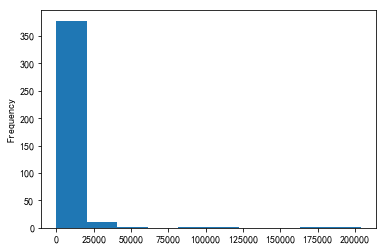

In [19]:
x=df_train.attendance
x.plot(kind='hist')

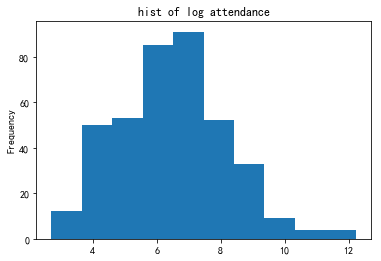

In [20]:
np.log(x).plot(kind='hist',title='hist of log attendance')

### What if my transformer doesn't exist
`FunctionTransformer`

- turn any function to transformer


In [24]:
from sklearn.preprocessing import FunctionTransformer
logger = FunctionTransformer(np.log1p)
X_log = logger.transform(X_train)

- or Write your own custom transformer

In [23]:
from sklearn.base import TransformerMixin

In [24]:
class Log1pTransformer(TransformerMixin):
    
    def fit(self, X, y=None):
        return None
    
    def transform(self, X):
        Xlog = np.log1p(X)
        return Xlog

One hot encoding
- turn string column into dummy variables


what `DictVectorizer` do

In [45]:
v = DictVectorizer(sparse=False)
D = [{'foo':1,'bar':2},{'foo':3,'baz':1}]
X = v.fit_transform(D)
X

array([[ 2.,  0.,  1.],
       [ 0.,  1.,  3.]])

In [46]:
pd.DataFrame(D)

,bar,baz,foo
0,2.0,NaN,1
1,NaN,1.0,3


In [47]:
df.head()

,application_date,permit_status,permit_type,event_category,event_sub_category,name_of_event,year_month_app,event_start_date,event_end_date,event_location_park,event_location_neighborhood,council_district,precinct,organization,attendance
0,12/09/2015 12:00:00 AM,Complete,Special Event,Athletic,Run/Walk,See Jane Run Women's Half Marathon and 5K,S16JY044,07/10/2016 12:00:00 AM,07/10/2016 12:00:00 AM,Gas Works Park,Multiple Neighborhoods,3,North,See Jane Run,4500.0
1,01/07/2016 12:00:00 AM,Complete,Special Event,Commercial,NaN,Capitol Hill Block Party,S16JY046,07/22/2016 12:00:00 AM,07/24/2016 12:00:00 AM,NaN,Capitol Hill,3,East,Independent Event Solutions,27000.0
2,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.09),S16JY074,07/09/2016 12:00:00 AM,07/09/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0
3,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.13),S16JY075,07/13/2016 12:00:00 AM,07/13/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0
4,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.31),S16JY076,07/31/2016 12:00:00 AM,07/31/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0


In [43]:
from sklearn.feature_extraction import DictVectorizer

In [39]:
class DummyTransformer(TransformerMixin):

    def __init__(self):
        self.dv = None

    def fit(self, X, y=None):
        # assumes all columns of X are strings
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        # drop column indicating NaNs
        nan_cols = [c for c in cols if '=' not in c]
        Xdum = Xdum.drop(nan_cols, axis=1)
        return Xdum

In [64]:
v = DictVectorizer(sparse=False)
D = test_df.to_dict('records')
X = v.fit(D)
X = v.fit_transform(D)
X

array([[  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   1.],
       [  0.,   1.,   0.,   1.,   0.,   0.,  nan,   0.,  nan,   0.,   1.],
       [  0.,   0.,   1.,   0.,   0.,   1.,  nan,   0.,  nan,   0.,   1.],
       [  0.,   0.,   1.,   0.,   0.,   1.,  nan,   0.,  nan,   0.,   1.],
       [  0.,   0.,   1.,   0.,   0.,   1.,  nan,   0.,  nan,   0.,   1.]])

useage:

In [53]:
CAT_FEATS = [
    'permit_type', 'event_category', 'event_sub_category',
    'event_location_park', 'event_location_neighborhood'
]
test_df = df[CAT_FEATS].head()
test_df

,permit_type,event_category,event_sub_category,event_location_park,event_location_neighborhood
0,Special Event,Athletic,Run/Walk,Gas Works Park,Multiple Neighborhoods
1,Special Event,Commercial,NaN,NaN,Capitol Hill
2,Special Event,Community,NaN,NaN,Pioneer Square
3,Special Event,Community,NaN,NaN,Pioneer Square
4,Special Event,Community,NaN,NaN,Pioneer Square


In [55]:
dummy = DummyTransformer()
dummy.fit(test_df)
dummy.transform(test_df)

,event_category=Athletic,event_category=Commercial,event_category=Community,event_location_neighborhood=Capitol Hill,event_location_neighborhood=Multiple Neighborhoods,event_location_neighborhood=Pioneer Square,event_location_park=Gas Works Park,event_sub_category=Run/Walk,permit_type=Special Event
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


another way to get one hot encode 
`get_dummies`

In [82]:
pd.get_dummies(test_df)

,permit_type_Special Event,event_category_Athletic,event_category_Commercial,event_category_Community,event_sub_category_Run/Walk,event_location_park_Gas Works Park,event_location_neighborhood_Capitol Hill,event_location_neighborhood_Multiple Neighborhoods,event_location_neighborhood_Pioneer Square
0,1,1,0,0,1,1,0,1,0
1,1,0,1,0,0,0,1,0,0
2,1,0,0,1,0,0,0,0,1
3,1,0,0,1,0,0,0,0,1
4,1,0,0,1,0,0,0,0,1


## Customer Transformer 

### One Hot Encoding

In [93]:
test_df

,permit_type,event_category,event_sub_category,event_location_park,event_location_neighborhood
0,Special Event,Athletic,Run/Walk,Gas Works Park,Multiple Neighborhoods
1,Special Event,Commercial,NaN,NaN,Capitol Hill
2,Special Event,Community,NaN,NaN,Pioneer Square
3,Special Event,Community,NaN,NaN,Pioneer Square
4,Special Event,Community,NaN,NaN,Pioneer Square


In [91]:
class DummyTransformer2(TransformerMixin):
    
    def fit(self,X, y=None):
        return self
    def transform(self,X):
        Xdum = pd.get_dummies(X)
        return Xdum

In [92]:
dummy = DummyTransformer2()
dummy.transform(test_df)

,permit_type_Special Event,event_category_Athletic,event_category_Commercial,event_category_Community,event_sub_category_Run/Walk,event_location_park_Gas Works Park,event_location_neighborhood_Capitol Hill,event_location_neighborhood_Multiple Neighborhoods,event_location_neighborhood_Pioneer Square
0,1,1,0,0,1,1,0,1,0
1,1,0,1,0,0,0,1,0,0
2,1,0,0,1,0,0,0,0,1
3,1,0,0,1,0,0,0,0,1
4,1,0,0,1,0,0,0,0,1


### DateFormatter

In [96]:
DATE_FEATS = ['application_date', 'event_start_date', 'event_end_date']
df[DATE_FEATS].head()

,application_date,event_start_date,event_end_date
0,12/09/2015 12:00:00 AM,07/10/2016 12:00:00 AM,07/10/2016 12:00:00 AM
1,01/07/2016 12:00:00 AM,07/22/2016 12:00:00 AM,07/24/2016 12:00:00 AM
2,01/21/2016 12:00:00 AM,07/09/2016 12:00:00 AM,07/09/2016 12:00:00 AM
3,01/21/2016 12:00:00 AM,07/13/2016 12:00:00 AM,07/13/2016 12:00:00 AM
4,01/21/2016 12:00:00 AM,07/31/2016 12:00:00 AM,07/31/2016 12:00:00 AM


In [98]:
df[DATE_FEATS].head().apply(pd.to_datetime)

,application_date,event_start_date,event_end_date
0,2015-12-09,2016-07-10,2016-07-10
1,2016-01-07,2016-07-22,2016-07-24
2,2016-01-21,2016-07-09,2016-07-09
3,2016-01-21,2016-07-13,2016-07-13
4,2016-01-21,2016-07-31,2016-07-31


In [99]:
class DateFormatter(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transformer(self, X):
        Xdate = X.apply(pd.to_datetime)
        return Xdate

In [109]:
date = DateFormatter()
temp_date_df = date.transformer(df[DATE_FEATS].head())
temp_date_df

,application_date,event_start_date,event_end_date
0,2015-12-09,2016-07-10,2016-07-10
1,2016-01-07,2016-07-22,2016-07-24
2,2016-01-21,2016-07-09,2016-07-09
3,2016-01-21,2016-07-13,2016-07-13
4,2016-01-21,2016-07-31,2016-07-31


### Clip transformer

In [121]:
class ClipTransformer(TransformerMixin):

    def __init__(self, a_min, a_max):
        self.a_min = a_min
        self.a_max = a_max

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xclip = np.clip(X, self.a_min, self.a_max)
        return Xclip

In [126]:
attendance = df.attendance
clip = ClipTransformer(1000,10000)
clip.transform(attendance).head()

0     4500.0
1    10000.0
2     1000.0
3     1000.0
4     1000.0
Name: attendance, dtype: float64

### Column Extractor

In [127]:
class ColumnExtractor(TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols

In [130]:
CAT_FEATS = [
    'permit_type', 'event_category', 'event_sub_category',
    'event_location_park', 'event_location_neighborhood'
]
cols = ColumnExtractor(CAT_FEATS)
cols.transform(df.head())

,permit_type,event_category,event_sub_category,event_location_park,event_location_neighborhood
0,Special Event,Athletic,Run/Walk,Gas Works Park,Multiple Neighborhoods
1,Special Event,Commercial,NaN,NaN,Capitol Hill
2,Special Event,Community,NaN,NaN,Pioneer Square
3,Special Event,Community,NaN,NaN,Pioneer Square
4,Special Event,Community,NaN,NaN,Pioneer Square


In [131]:
NUM_FEATS = ['attendance']
cols = ColumnExtractor(NUM_FEATS)
cols.transform(df.head())

,attendance
0,4500.0
1,27000.0
2,705.0
3,705.0
4,705.0


### data frame -- FeatureUnion

In [134]:
from functools import reduce

In [138]:
class DFFeatureUnion(TransformerMixin):
    # FeatureUnion but for pandas DataFrames

    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def fit(self, X, y=None):
        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion

In [139]:
class ZeroFillTransformer(TransformerMixin):

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xz = X.fillna(value=0)
        return Xz

In [147]:
trans_list = [
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer2())
        ])),
        ('numerics', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS)),
            ('zero_fill', ZeroFillTransformer()),
            ('log', Log1pTransformer())
        ]))
    ]

In [165]:
feats=DFFeatureUnion(trans_list)
feats.fit(df)
feats_df = feats.transform(df)
feats_df.head()

,permit_type_Charter Vessel,permit_type_Special Event,permit_type_Valet Parking,event_category_Athletic,event_category_Citywide,event_category_Commercial,event_category_Community,event_category_Free Speech,event_category_Mixed Free Speech,event_sub_category_Cycling,...,event_location_neighborhood_Seward Park,event_location_neighborhood_Sodo,event_location_neighborhood_South Lake Union,event_location_neighborhood_South Park,event_location_neighborhood_University District,event_location_neighborhood_Wallingford,event_location_neighborhood_Wedgwood,event_location_neighborhood_West Seattle,event_location_neighborhood_Westlake,attendance
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.412055
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.203629
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.559615
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.559615
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.559615


### data frame -- StandardScaler

In [173]:
class DFStandardScaler(TransformerMixin):
    # StandardScaler but for pandas DataFrames

    def __init__(self):
        self.ss = None
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None):
        self.ss = StandardScaler()
        self.ss.fit(X)
        self.mean_ = pd.Series(self.ss.mean_, index=X.columns)
        self.scale_ = pd.Series(self.ss.scale_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xss = self.ss.transform(X)
        Xscaled = pd.DataFrame(Xss, index=X.index, columns=X.columns)
        return Xscaled

In [175]:
feats_scale = DFStandardScaler()
feats_scale.fit(feats_df)
feats_scale.transform(feats_df).head()

,permit_type_Charter Vessel,permit_type_Special Event,permit_type_Valet Parking,event_category_Athletic,event_category_Citywide,event_category_Commercial,event_category_Community,event_category_Free Speech,event_category_Mixed Free Speech,event_sub_category_Cycling,...,event_location_neighborhood_Seward Park,event_location_neighborhood_Sodo,event_location_neighborhood_South Lake Union,event_location_neighborhood_South Park,event_location_neighborhood_University District,event_location_neighborhood_Wallingford,event_location_neighborhood_Wedgwood,event_location_neighborhood_West Seattle,event_location_neighborhood_Westlake,attendance
0,-0.152351,0.485779,-0.449747,2.386672,-0.107109,-0.464857,-0.764089,-0.323085,-0.087287,-0.115801,...,-0.075521,-0.253745,-0.213201,-0.043519,-0.198224,-0.231916,-0.043519,-0.182217,-0.043519,1.080536
1,-0.152351,0.485779,-0.449747,-0.418994,-0.107109,2.151200,-0.764089,-0.323085,-0.087287,-0.115801,...,-0.075521,-0.253745,-0.213201,-0.043519,-0.198224,-0.231916,-0.043519,-0.182217,-0.043519,2.058766
2,-0.152351,0.485779,-0.449747,-0.418994,-0.107109,-0.464857,1.308748,-0.323085,-0.087287,-0.115801,...,-0.075521,-0.253745,-0.213201,-0.043519,-0.198224,-0.231916,-0.043519,-0.182217,-0.043519,0.069072
3,-0.152351,0.485779,-0.449747,-0.418994,-0.107109,-0.464857,1.308748,-0.323085,-0.087287,-0.115801,...,-0.075521,-0.253745,-0.213201,-0.043519,-0.198224,-0.231916,-0.043519,-0.182217,-0.043519,0.069072
4,-0.152351,0.485779,-0.449747,-0.418994,-0.107109,-0.464857,1.308748,-0.323085,-0.087287,-0.115801,...,-0.075521,-0.253745,-0.213201,-0.043519,-0.198224,-0.231916,-0.043519,-0.182217,-0.043519,0.069072


## Combine pipeline

In [176]:
pipeline = Pipeline([
    ('features', DFFeatureUnion([
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer())
        ])),
        ('numerics', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS)),
            ('zero_fill', ZeroFillTransformer()),
            ('log', Log1pTransformer())
        ]))
    ])),
    ('scale', DFStandardScaler())
])
pipeline.fit(df_train)
X_train_2 = pipeline.transform(df_train)
X_test_2 = pipeline.transform(df_test)


In [179]:
# fit model
model_2 = LogisticRegression(random_state=5678)
model_2.fit(X_train_2, y_train)
y_pred_train_2 = model_2.predict(X_train_2)
p_pred_train_2 = model_2.predict_proba(X_train_2)[:, 1]

In [180]:
# Evaluate model
p_pred_test_2 = model_2.predict_proba(X_test_2)[:, 1]
auc_test_2 = roc_auc_score(y_test, p_pred_test_2)
print(auc_test_2)  # 0.705084745763


0.705084745763
